In [44]:
import pandas as pd
import numpy as np


In [45]:
df = pd.read_csv("financial_data.csv")

In [46]:
df.head()

,transaction_id,timestamp,amount,country,method,gateway,status
0,TRX_00000,2026-01-11 23:15:00,136217.91,Nigeria,card,Flutterwave,0
1,TRX_00001,2026-01-01 14:20:00,106757.12,Nigeria,bank_transfer,Flutterwave,0
2,TRX_00002,2026-01-27 11:58:00,301991.10,South Africa,bank_transfer,Stripe,1
3,TRX_00003,2026-01-08 20:04:00,252058.16,Kenya,card,Paystack,1
4,TRX_00004,2026-01-05 08:25:00,433606.46,Egypt,card,Paystack,1


In [47]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   transaction_id  10000 non-null  object 
 1   timestamp       10000 non-null  object 
 2   amount          10000 non-null  float64
 3   country         10000 non-null  object 
 4   method          10000 non-null  object 
 5   gateway         10000 non-null  object 
 6   status          10000 non-null  int64  
dtypes: float64(1), int64(1), object(5)
memory usage: 547.0+ KB


In [48]:
# Grouppin the time

# Extract the hour from the timestamp
df['hour'] = pd.to_datetime(df['timestamp']).dt.hour

# 0-6: Night | 6-12: Morning | 12-18: Afternoon | 18-24: Night
bins = [0, 6, 12, 18, 24]
labels = ['Night', 'Morning', 'Afternoon', 'Evening']


In [49]:
# Create the 'time_of_day' feature
df['time_of_day'] = pd.cut(df['hour'], bins=bins, labels=labels, include_lowest=True)

print(df[['hour', 'time_of_day']].head(10))


   hour time_of_day
0    23     Evening
1    14   Afternoon
2    11     Morning
3    20     Evening
4     8     Morning
5    16   Afternoon
6    19     Evening
7     6       Night
8     3       Night
9    12     Morning

In [50]:
df.head()

,transaction_id,timestamp,amount,country,method,gateway,status,hour,time_of_day
0,TRX_00000,2026-01-11 23:15:00,136217.91,Nigeria,card,Flutterwave,0,23,Evening
1,TRX_00001,2026-01-01 14:20:00,106757.12,Nigeria,bank_transfer,Flutterwave,0,14,Afternoon
2,TRX_00002,2026-01-27 11:58:00,301991.10,South Africa,bank_transfer,Stripe,1,11,Morning
3,TRX_00003,2026-01-08 20:04:00,252058.16,Kenya,card,Paystack,1,20,Evening
4,TRX_00004,2026-01-05 08:25:00,433606.46,Egypt,card,Paystack,1,8,Morning


In [51]:
# Separate Features and Target

X = df.drop(columns=['status', 'transaction_id', 'timestamp'])
y = df['status']

# Force convert problematic columns and handle errors
cols_to_fix = ['amount', 'hour']

for col in cols_to_fix:
    # errors='coerce' will turn any string it can't parse (like scientific notation artifacts) into NaN
    X[col] = pd.to_numeric(X[col], errors='coerce')

# Check if any NaNs were created (these are our "scientific notation" culprits)
nan_count = X[cols_to_fix].isna().sum().sum()

if nan_count > 0:
    print(f"Detected and fixed {nan_count} corrupted scientific notation strings.")
    # Drop the rows with NaNs to keep the dataset clean for XGBoost
    X = X.dropna()
    y = y[X.index]
else:
    print("No numerical corruption detected. The issue may be in the 'time_of_day' category.")

# Ensure time_of_day is treated as a string for the OneHotEncoder
X['time_of_day'] = X['time_of_day'].astype(str)



# Group features for the pipeline
numeric_features = ['amount', 'hour']
categorical_features = ['country', 'method', 'gateway', 'time_of_day']

No numerical corruption detected. The issue may be in the 'time_of_day' category.


In [52]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# Create a transformer for numerical data (scaling)
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

# Create a transformer for categorical data (encoding)
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combine them into a ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])


print("Pipeline structure created successfully!")

Pipeline structure created successfully!


In [53]:
from sklearn.metrics import (accuracy_score, classification_report, confusion_matrix)
from sklearn.model_selection import train_test_split

In [54]:
# train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42, stratify = y)

BUILDING THE BASELINE MODEL (RULE-BASED MODEL)

In [55]:
def moneyhash_style_router(row):
    # High-Value Transaction Rule (Amount > 100,000)
    # MoneyHash users often route large amounts to specific high-tier gateways
    if row['amount'] > 100000:
        return 'Stripe' 
    
    # Regional Excellence Rules
    if row['country'] == 'Nigeria':
        if row['method'] == 'card':
            return 'Paystack'
        else:
            return 'Flutterwave'
            
    if row['country'] == 'Kenya':
        return 'Flutterwave'
    
    # Default / Fallback Gateway
    return 'Stripe'

# By applying the MoneyHash-style rules
df['moneyhash_rule_output'] = df.apply(moneyhash_style_router, axis=1)

# Calculating the success rate for the MoneyHash baseline
# (Success if the chosen gateway matches a '1' status in our synthetic data)
baseline_success = df[df['gateway'] == df['moneyhash_rule_output']]['status'].mean()

print(f"MoneyHash-Style Rule Success Rate: {baseline_success:.2%}")

MoneyHash-Style Rule Success Rate: 81.09%


Testing the Rule-Based model on our X_test dataset

In [56]:
# Generate predictions using your rule-based function
test_df = X_test.copy() # Use your preprocessed test set

# If you kept the original 'country' etc. in X_test, you can apply the function:
test_df['rule_output'] = test_df.apply(moneyhash_style_router, axis=1)

# Add the actual 'status' and 'gateway' back for comparison
test_df['actual_gateway'] = df.loc[test_df.index, 'gateway']
test_df['actual_status'] = y_test

# Define "Success" for the rule-based model
# A rule is successful if it picked a gateway that actually succeeded in the data
rule_success_count = test_df[
    (test_df['rule_output'] == test_df['actual_gateway']) & 
    (test_df['actual_status'] == 1)
].shape[0]

total_test_transactions = test_df.shape[0]
rule_accuracy = (rule_success_count / total_test_transactions)

print(f"Rule-Based System successfully routed {rule_success_count} out of {total_test_transactions} transactions.")
print(f"Final Success Rate: {rule_accuracy:.2%}")

Rule-Based System successfully routed 516 out of 2000 transactions.
Final Success Rate: 25.80%


Building the ML model

In [57]:
import pandas as pd
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [58]:
# Define the Full Pipeline (The "Predictive Router")
# Using the specific parameters you've used in your financial risk projects
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', XGBClassifier(
        n_estimators=100, 
        learning_rate=0.1, 
        max_depth=5, 
        random_state=42
    ))
])

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the Model
model_pipeline.fit(X_train, y_train)

# Performance Test
y_pred = model_pipeline.predict(X_test)
ml_accuracy = accuracy_score(y_test, y_pred)

print(f"--- POC RESULTS ---")
print(f"ML Model Success Rate: {ml_accuracy:.2%}")

--- POC RESULTS ---
ML Model Success Rate: 84.15%


In [59]:
# Assuming you already ran the rule_based_router on the test set
# comparison code

improvement = ml_accuracy - 0.2580 # Your baseline score
failure_reduction = (improvement / (1 - 0.2580)) * 100

print(f"Improvement over Rules: {improvement*100:.2f} percentage points")
print(f"Total Reduction in Failures: {failure_reduction:.2f}%")

Improvement over Rules: 58.35 percentage points
Total Reduction in Failures: 78.64%


## SHAP Explainability Code

PermutationExplainer explainer: 2001it [02:09, 14.42it/s]                          
C:\Users\DELL\AppData\Local\Temp\ipykernel_5664\126173049.py:10: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_test_transformed, feature_names=feature_names)


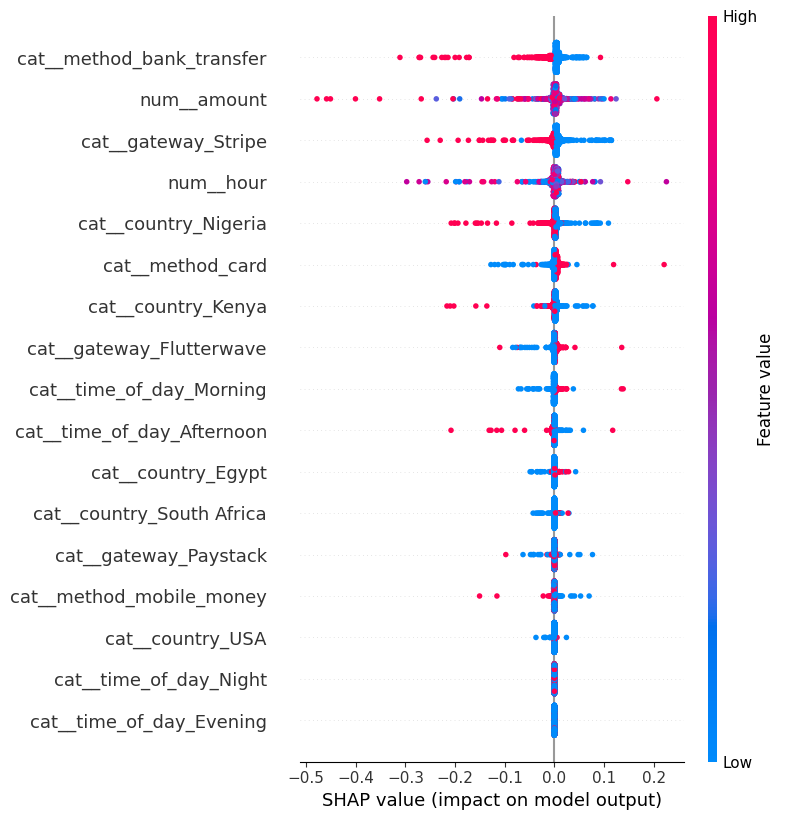

In [60]:
# 1. Get the actual model from the pipeline
model = model_pipeline.named_steps['classifier']

# 2. Use the classifier's predict function directly 
# This expects the 17 features that X_test_transformed already has
explainer = shap.Explainer(model.predict, X_test_transformed)
shap_values = explainer(X_test_transformed)

# 3. Plotting the results
shap.summary_plot(shap_values, X_test_transformed, feature_names=feature_names)

In [61]:
import joblib

# Save the entire pipeline (preprocessor + XGBoost)
joblib.dump(model_pipeline, 'moneyhash_router_v1.pkl')
print("Model saved as moneyhash_router_v1.pkl")

Model saved as moneyhash_router_v1.pkl
